In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-malware-prediction/sample_submission.csv
/kaggle/input/microsoft-malware-prediction/train.csv
/kaggle/input/microsoft-malware-prediction/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)


from keras import callbacks
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam


pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_train = pd.read_csv("/kaggle/input/microsoft-malware-prediction/train.csv")
#sampling
sample=100000
df_train = df_train.sample(sample)
# x=gc.collect()

/tmp/ipykernel_20/2127578741.py:1: DtypeWarning:

Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
df_train

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
5399222,9af801a35fbc3743683e80374f27a5ec,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1320.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,189,111332.0,NaN,277.0,75,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2102.0,249154.0,4.0,5.0,2412.0,NaN,122104.0,SSD,120635.0,0,4096.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.17134.285,amd64,rs4_release,17134,285,Professional,PROFESSIONAL,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,486.0,56002.0,1,NaN,0.0,0,0,0.0,1.0,10.0,0
4419811,7edbf927be38b571df6d7b9658bf30d5,win8defender,1.1.14600.4,4.10.14393.1613,1.263.146.0,0,7.0,0,NaN,61454.0,2.0,2.0,1,141,56206.0,27.0,167.0,227,windows10,x64,10.0.0.0,14393,768,rs1,14393.1715.amd64fre.rs1_release_inmarket.17090...,Home,0.0,0,NaN,NaN,96.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,4730.0,311992.0,4.0,5.0,2257.0,NaN,476940.0,HDD,474988.0,0,3072.0,Notebook,14.0,1366.0,768.0,Mobile,lion,5.200000e+01,10.0.14393.1715,amd64,rs1_release,14393,1715,Core,CORE,Update,9.0,34,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,512.0,9391.0,0,0.0,0.0,0,0,0.0,0.0,10.0,0
4197811,7872f4d5d33885be48ebd7ac483c1548,win8defender,1.1.15200.1,4.18.1807.18075,1.275.245.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,173,5433.0,27.0,224.0,75,windows10,x86,10.0.0.0,17692,768,prers5,17692.1004.x86fre.rs_prerelease_flt.180625-1624,Home,1.0,0,NaN,0.0,163.0,NaN,1.0,1.0,SmallTablet,Windows.Desktop,1443.0,327738.0,4.0,5.0,1854.0,NaN,59640.0,SSD,52079.0,0,2048.0,Portable,8.0,1280.0,800.0,Slate,NaN,8.800000e+01,10.0.17692.1004,x86,rs_prerelease_flt,17692,1004,Core,CORE,UUPUpgrade,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,WIS,NaN,355.0,20317.0,1,NaN,0.0,1,1,1.0,0.0,11.0,0
3762948,6bfd3426344ae308a21c152f24684eda,win8defender,1.1.15100.1,4.18.1807.18075,1.273.894.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,66,30040.0,27.0,89.0,88,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,639.0,261634.0,4.0,5.0,2256.0,NaN,152627.0,HDD,137587.0,0,3072.0,Portable,15.6,1600.0,900.0,Mobile,NaN,4.294967e+09,10.0.17134.191,amd64,rs4_release,171

In [5]:
df_test = pd.read_csv("/kaggle/input/microsoft-malware-prediction/test.csv")
#sampling
sample=50000
df_test = df_test.sample(sample)
df_test

/tmp/ipykernel_20/3289367549.py:1: DtypeWarning:

Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.



,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
7462026,f33967ac6902fbd771d7c7bf4af8e86f,win8defender,1.1.15400.4,4.18.1810.5,1.279.720.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,214,146059.0,18.0,277.0,75,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,328540.0,4.0,5.0,2412.0,NaN,476940.0,HDD,103379.0,0,4096.0,Laptop,13.9,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,IS_GENUINE,Volume:GVLK,NaN,0.0,Retail,NaN,355.0,4319.0,0,NaN,0.0,0,0,0.0,0.0,1.0
7088804,e712370e5c821ed031ba4e3fa5856a01,win8defender,1.1.15300.6,4.18.1809.2,1.277.1050.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,201,106318.0,NaN,267.0,251,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,4730.0,300149.0,4.0,5.0,2525.0,NaN,715404.0,HDD,701655.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.547,amd64,rs3_release_svc_escrow,16299,547,CoreSingleLanguage,CORE_SINGLELANGUAGE,Update,35.0,148,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,556.0,4357.0,1,NaN,0.0,0,0,0.0,0.0,11.0
2267638,49e5930350c2ceb7f72e307d8d2b750e,win8defender,1.1.15400.5,4.18.1810.5,1.281.253.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,155474.0,NaN,205.0,172,windows10,x86,10.0.0.0,14393,256,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,Pro,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,3035.0,263512.0,2.0,5.0,3512.0,NaN,38166.0,Unspecified,37714.0,0,2048.0,Desktop,13.3,1024.0,768.0,Desktop,NaN,4.294967e+09,10.0.14393.2214,x86,rs1_release,14393,2214,Professional,PROFESSIONAL,Update,27.0,120,Notify,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,142.0,65124.0,0,0.0,0.0,0,0,0.0,1.0,15.0
6374925,cfd39c1f482792c8f39ff044a6b40909,win8defender,1.1.15400.5,4.18.1810.5,1.281.382.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,7,164633.0,NaN,211.0,182,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,1953.0,274451.0,4.0,5.0,2459.0,NaN,476940.0,HDD,199644.0,0,2048.0,Notebook,12.7,1024.0,768.0,Mobile,NaN,0.000000e+00,1

In [6]:
df_train.columns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5399222 to 278996
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  100000 non-null  object 
 1   ProductName                                        100000 non-null  object 
 2   EngineVersion                                      100000 non-null  object 
 3   AppVersion                                         100000 non-null  object 
 4   AvSigVersion                                       100000 non-null  object 
 5   IsBeta                                             100000 non-null  int64  
 6   RtpStateBitfield                                   99646 non-null   float64
 7   IsSxsPassiveMode                                   100000 non-null  int64  
 8   DefaultBrowsersIdentifier                          4913 non-null    

In [8]:
#missing value chart
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PuaMode,99966,99.966
Census_ProcessorClass,99604,99.604
DefaultBrowsersIdentifier,95087,95.087
Census_IsFlightingInternal,83054,83.054
Census_InternalBatteryType,70939,70.939
Census_ThresholdOptIn,63422,63.422
Census_IsWIMBootEnabled,63340,63.340
SmartScreen,35640,35.640
OrganizationIdentifier,30948,30.948
SMode,6052,6.052


In [9]:
#drop variables with missing values >=20% in the train dataframe
i=0
for col in df_train.columns:
    if (df_train[col].isnull().sum()/len(df_train[col])*100) >=10:
        print("Dropping column", col)
        df_train.drop(labels=col,axis=1,inplace=True)
        i=i+1
        
print("Total number of columns dropped in train dataframe", i)

Dropping column DefaultBrowsersIdentifier
Dropping column OrganizationIdentifier
Dropping column PuaMode
Dropping column SmartScreen
Dropping column Census_ProcessorClass
Dropping column Census_InternalBatteryType
Dropping column Census_IsFlightingInternal
Dropping column Census_ThresholdOptIn
Dropping column Census_IsWIMBootEnabled
Total number of columns dropped in train dataframe 9


In [10]:
 df_train.drop(columns='SMode',inplace=True)
    

In [11]:
#drop variables with missing values >=20% in the train dataframe
i=0
for col in df_test.columns:
    if (df_test[col].isnull().sum()/len(df_test[col])*100) >=10:
        print("Dropping column", col)
        df_test.drop(labels=col,axis=1,inplace=True)
        i=i+1
        
print("Total number of columns dropped in train dataframe", i)

Dropping column DefaultBrowsersIdentifier
Dropping column OrganizationIdentifier
Dropping column PuaMode
Dropping column SMode
Dropping column SmartScreen
Dropping column Census_ProcessorClass
Dropping column Census_InternalBatteryType
Dropping column Census_IsFlightingInternal
Dropping column Census_ThresholdOptIn
Dropping column Census_IsWIMBootEnabled
Total number of columns dropped in train dataframe 10


In [12]:
# Categorize attribute(column) based on its type
dtypes = df_train.dtypes
numerics = [ 'int64', 'float64']
num_columns = [c for c,v in dtypes.items() if v in numerics]
cat_columns = [c for c,v in dtypes.items() if v not in numerics]

print("Numerical Column : ",len(num_columns),"\n")
print(num_columns)
print("\n\nCategorical Column",len(cat_columns),"\n")
print(cat_columns)

Numerical Column :  47 

['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_IsPortableOperatingSystem', 'Ce

In [13]:
# impute missing value with mean and mode

def replace_missing_data(df, mis_vars):
    print('##### Replacing missing values with mode of features #####')
    for var in mis_vars:
        if var in cat_columns:
            df[var] = df[var].fillna(df[var].mode()[0])
        else:
            df[var] = df[var].fillna(df[var].mean())
    return df

In [14]:
mis_var = [var for var in df_train.columns if df_train[var].isnull().sum() > 0]
df_train = replace_missing_data(df_train, mis_var)

##### Replacing missing values with mode of features #####


In [15]:
mis_var = [var for var in df_test.columns if df_test[var].isnull().sum() > 0]
df_test = replace_missing_data(df_test, mis_var)

##### Replacing missing values with mode of features #####


In [16]:
#missing value chart
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
MachineIdentifier,0,0.0
Census_PrimaryDiskTypeName,0,0.0
Census_OSSkuName,0,0.0


In [17]:
df_train.shape, df_test.shape

((100000, 73), (50000, 72))

In [18]:
df_train.drop(columns=['MachineIdentifier'],inplace=True)
df_test.drop(columns=['MachineIdentifier'],inplace=True)  

In [19]:
df_train.shape, df_test.shape

((100000, 72), (50000, 71))

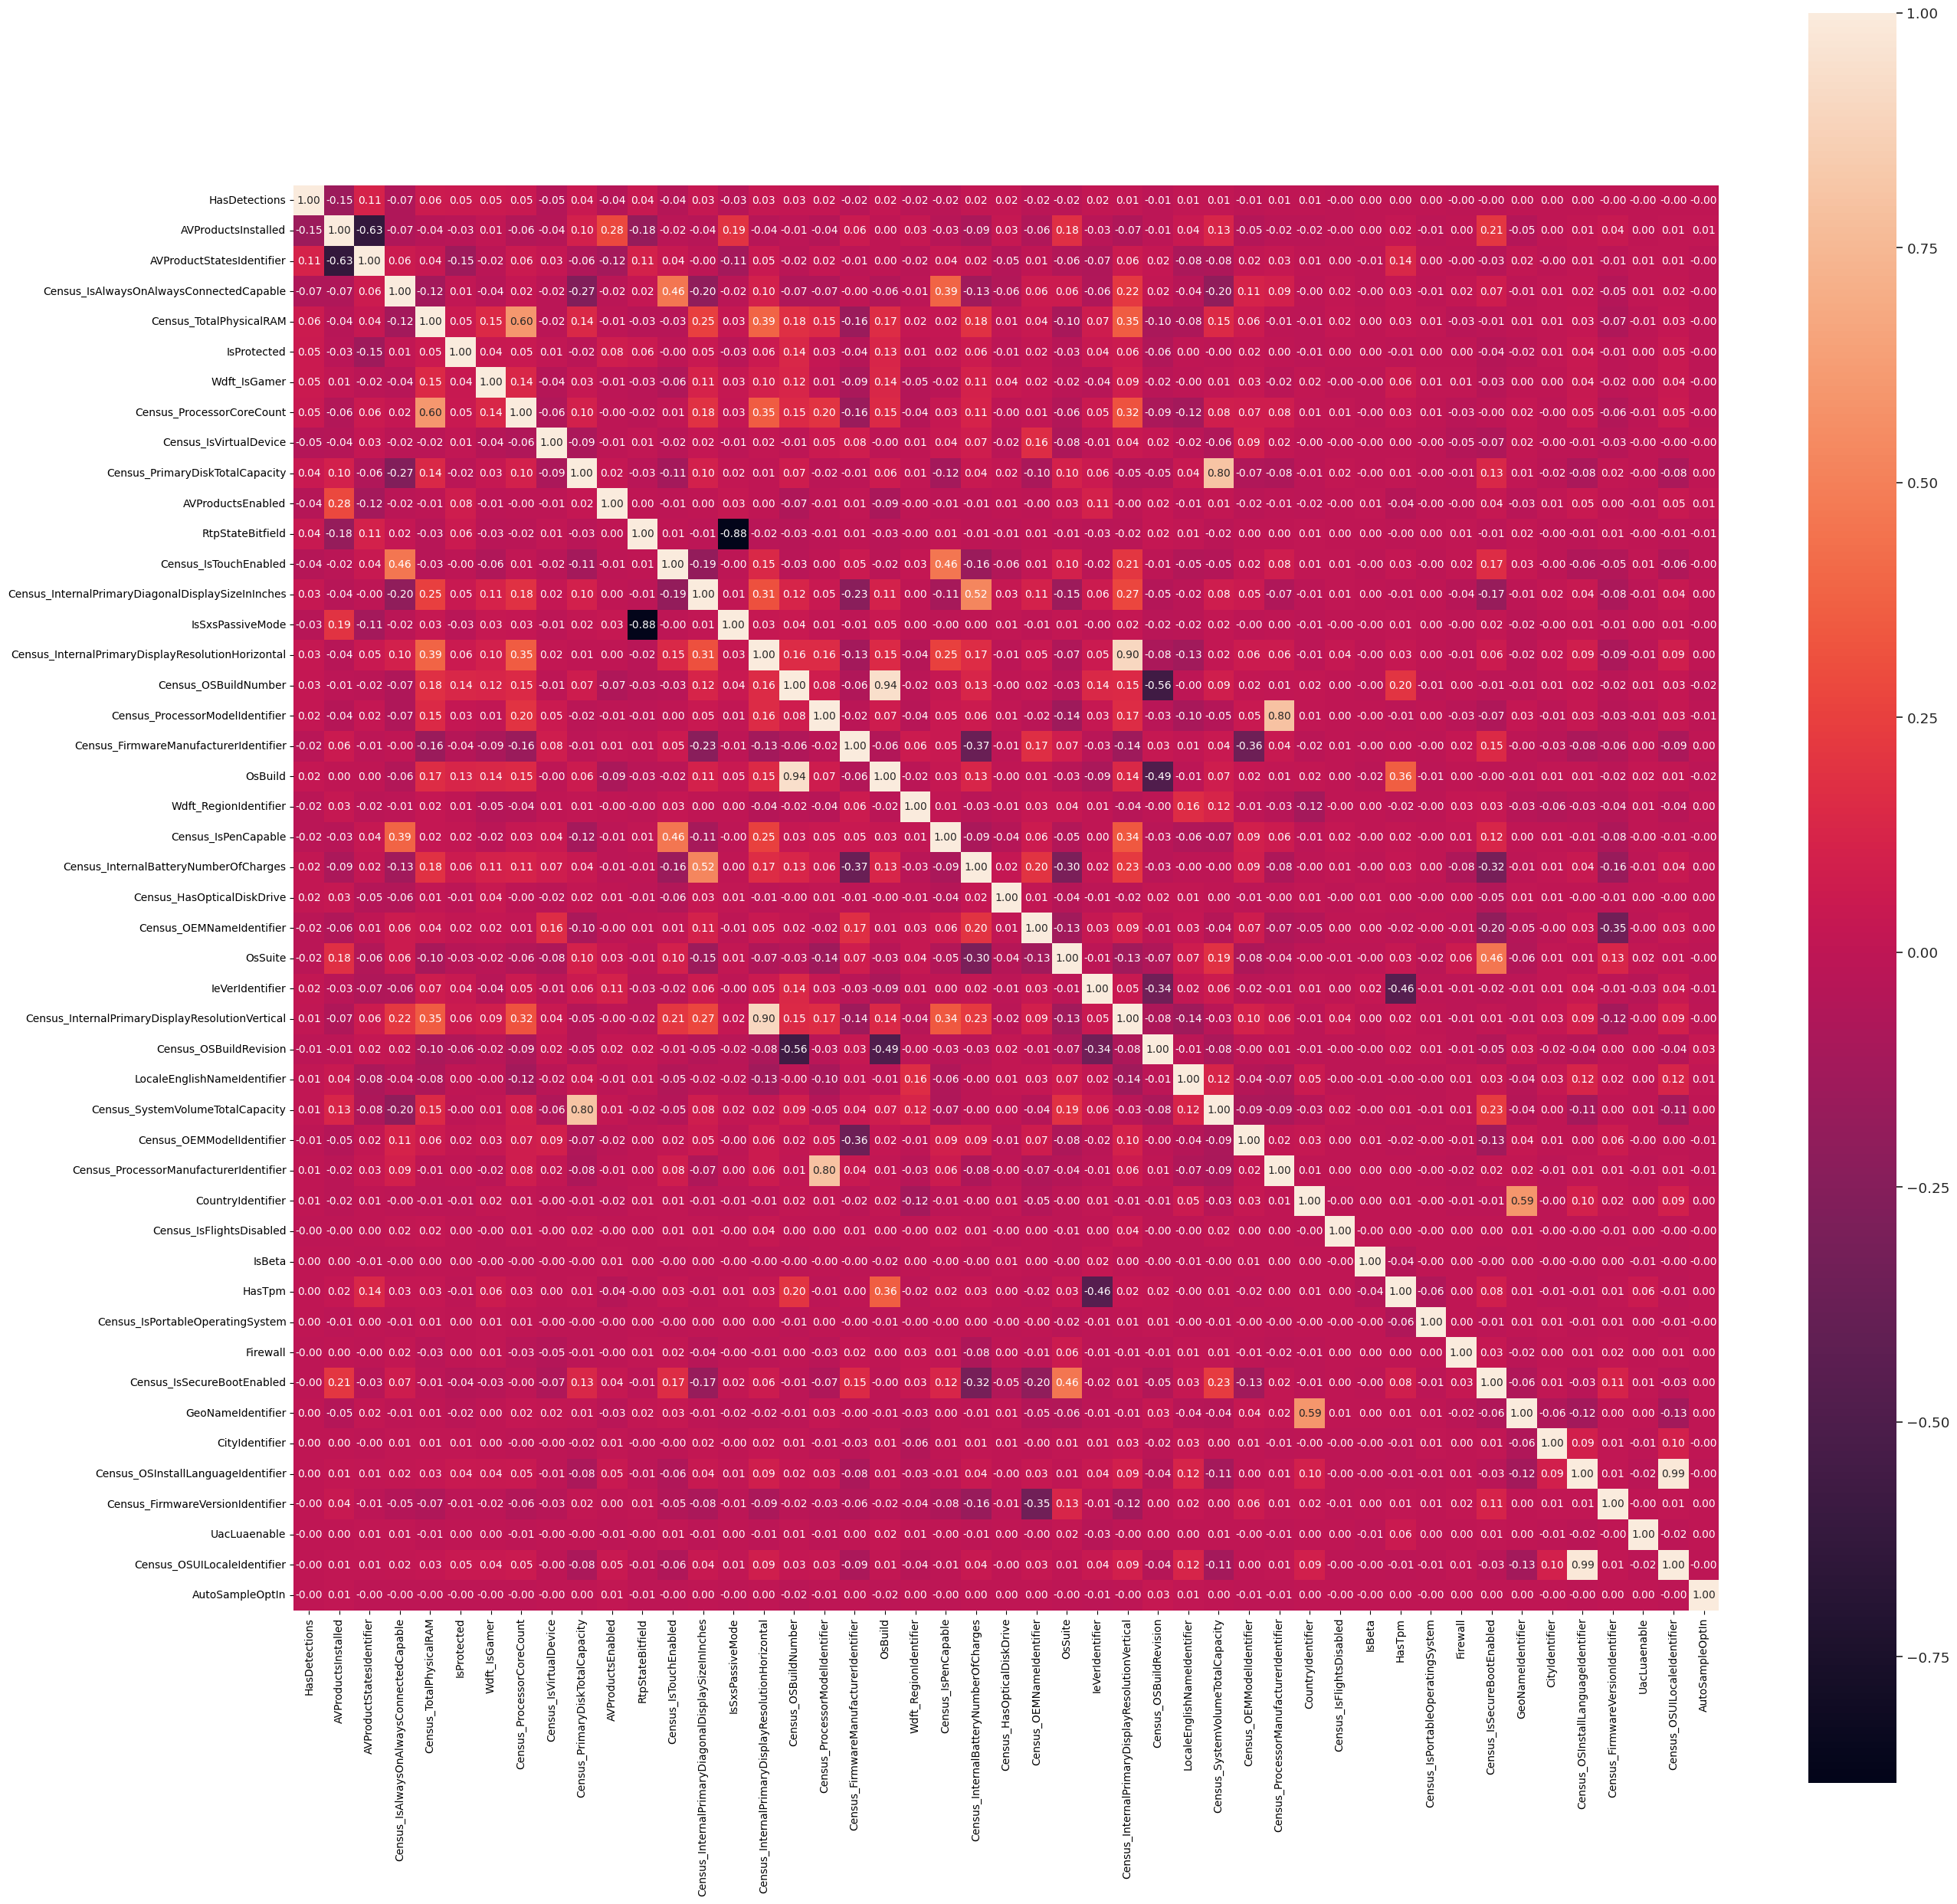

In [20]:
corrmat = df_train.corr().abs()
f, ax = plt.subplots(figsize=(30, 30))
cols = corrmat.nlargest(50, 'HasDetections')['HasDetections'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<AxesSubplot: xlabel='HasDetections', ylabel='count'>

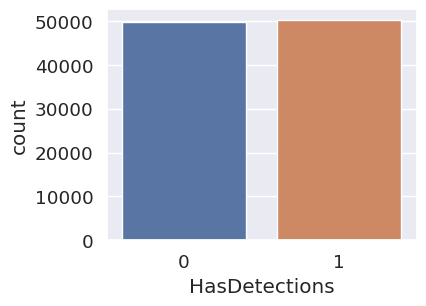

In [21]:
plt.figure(figsize=(4,3))
sns.countplot(x=df_train['HasDetections'])

Text(0.5, 0.98, 'Relation between HasDetections and 25 important features')

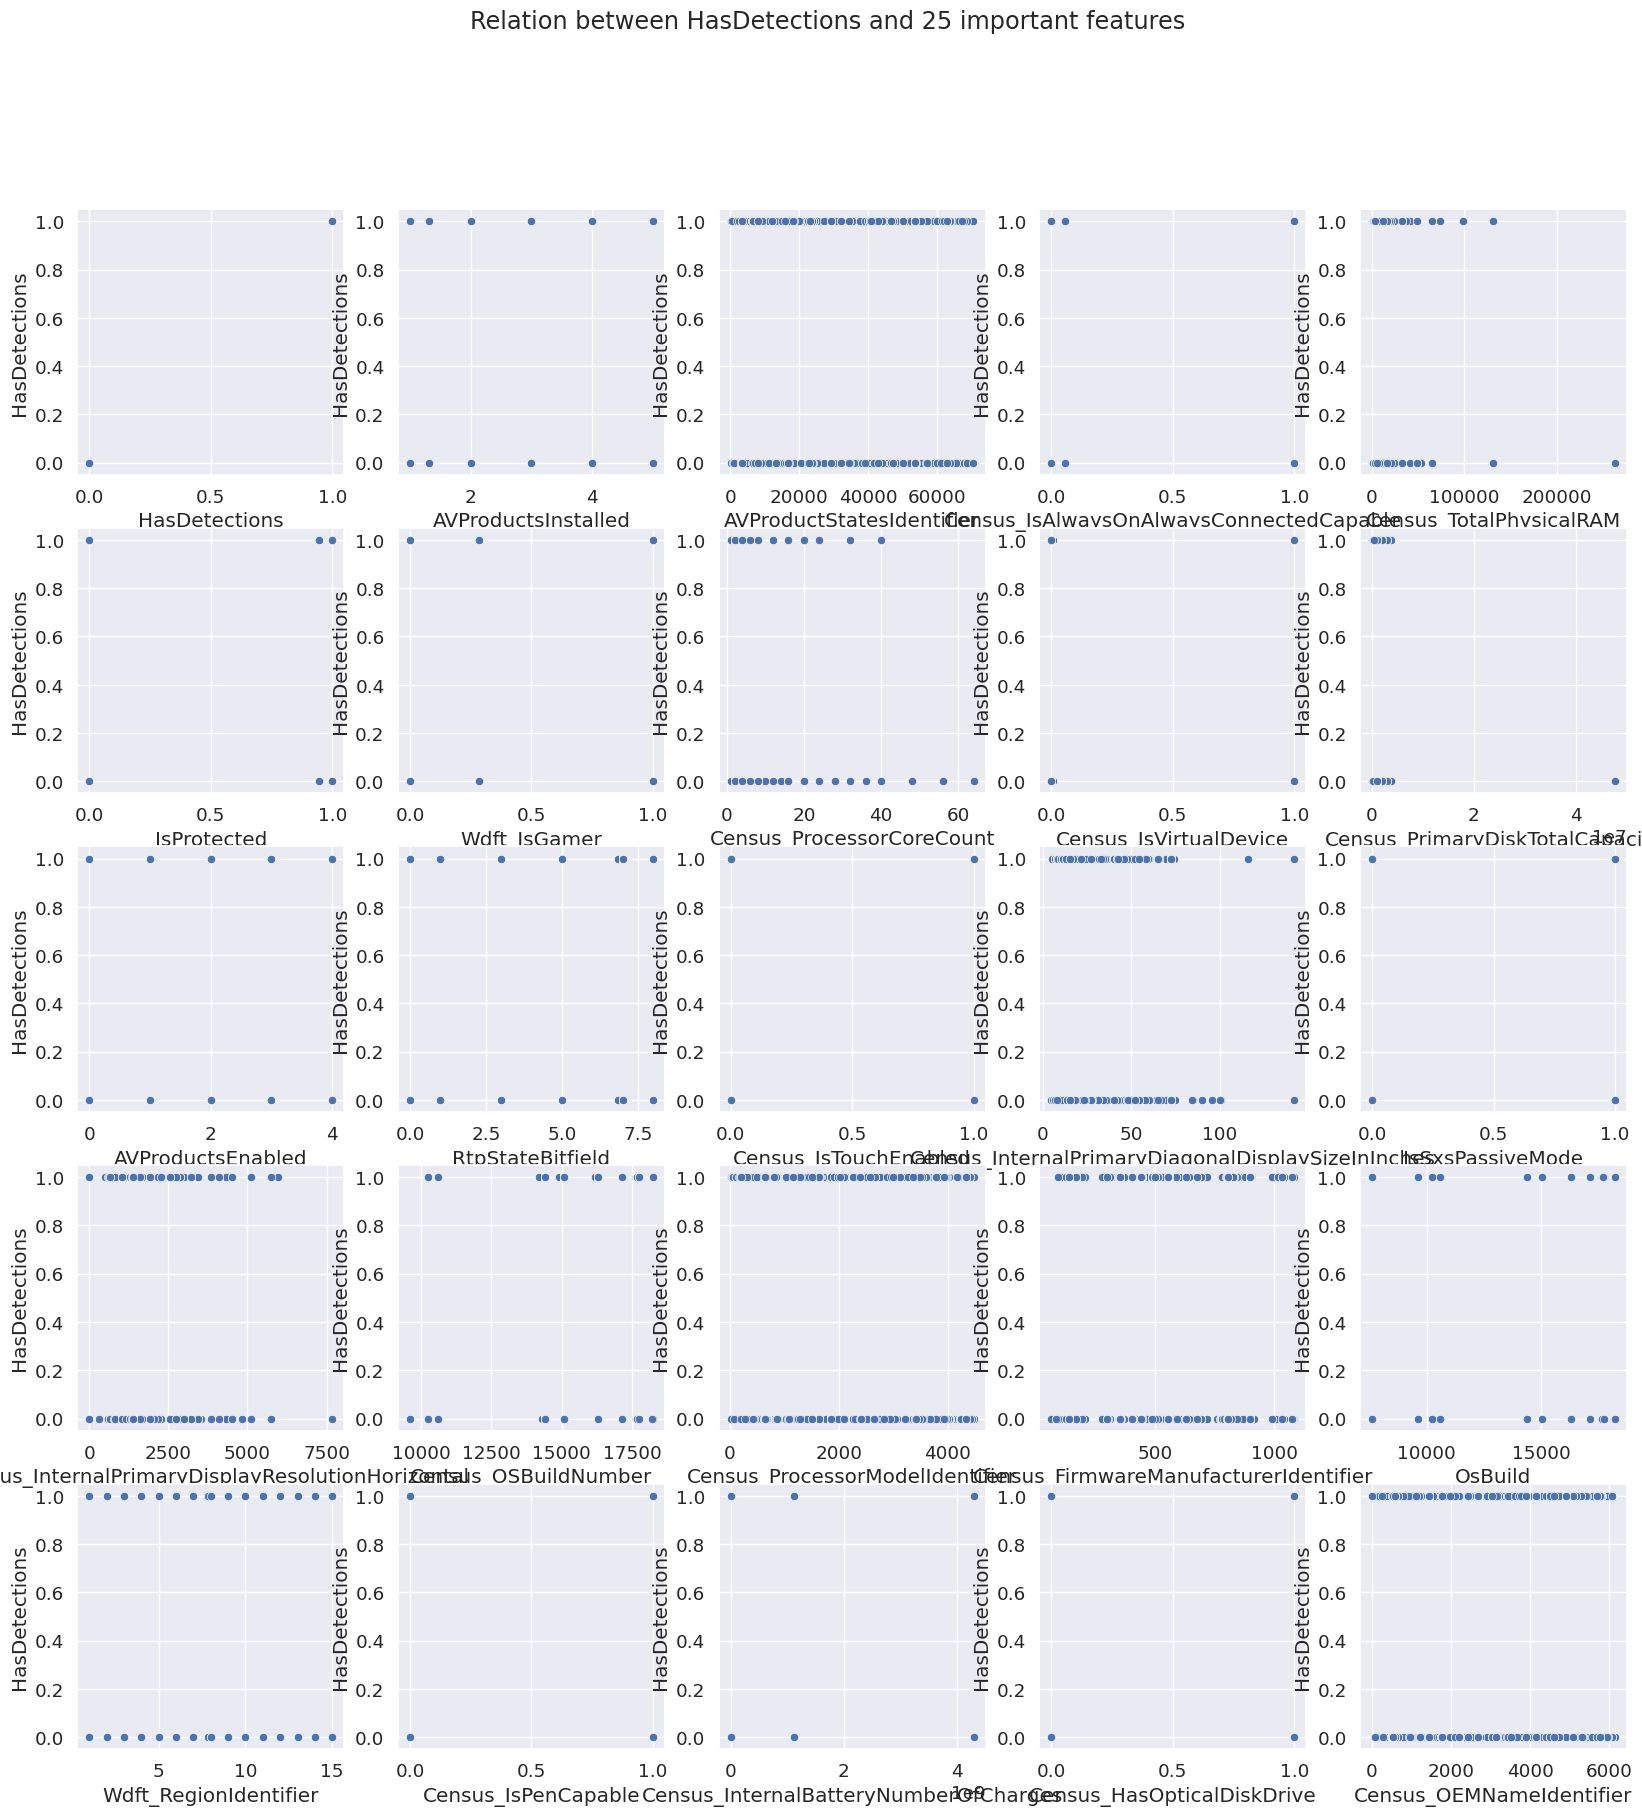

In [22]:
plt.figure(figsize=(20,20))
for i in range(len(cols[:25])):
    plt.subplot(5,5, i+1)
    sns.scatterplot(x=df_train[cols[i]], y=df_train['HasDetections'])
plt.suptitle('Relation between HasDetections and 25 important features')

Text(0.5, 0.98, 'Values for 25 important features')

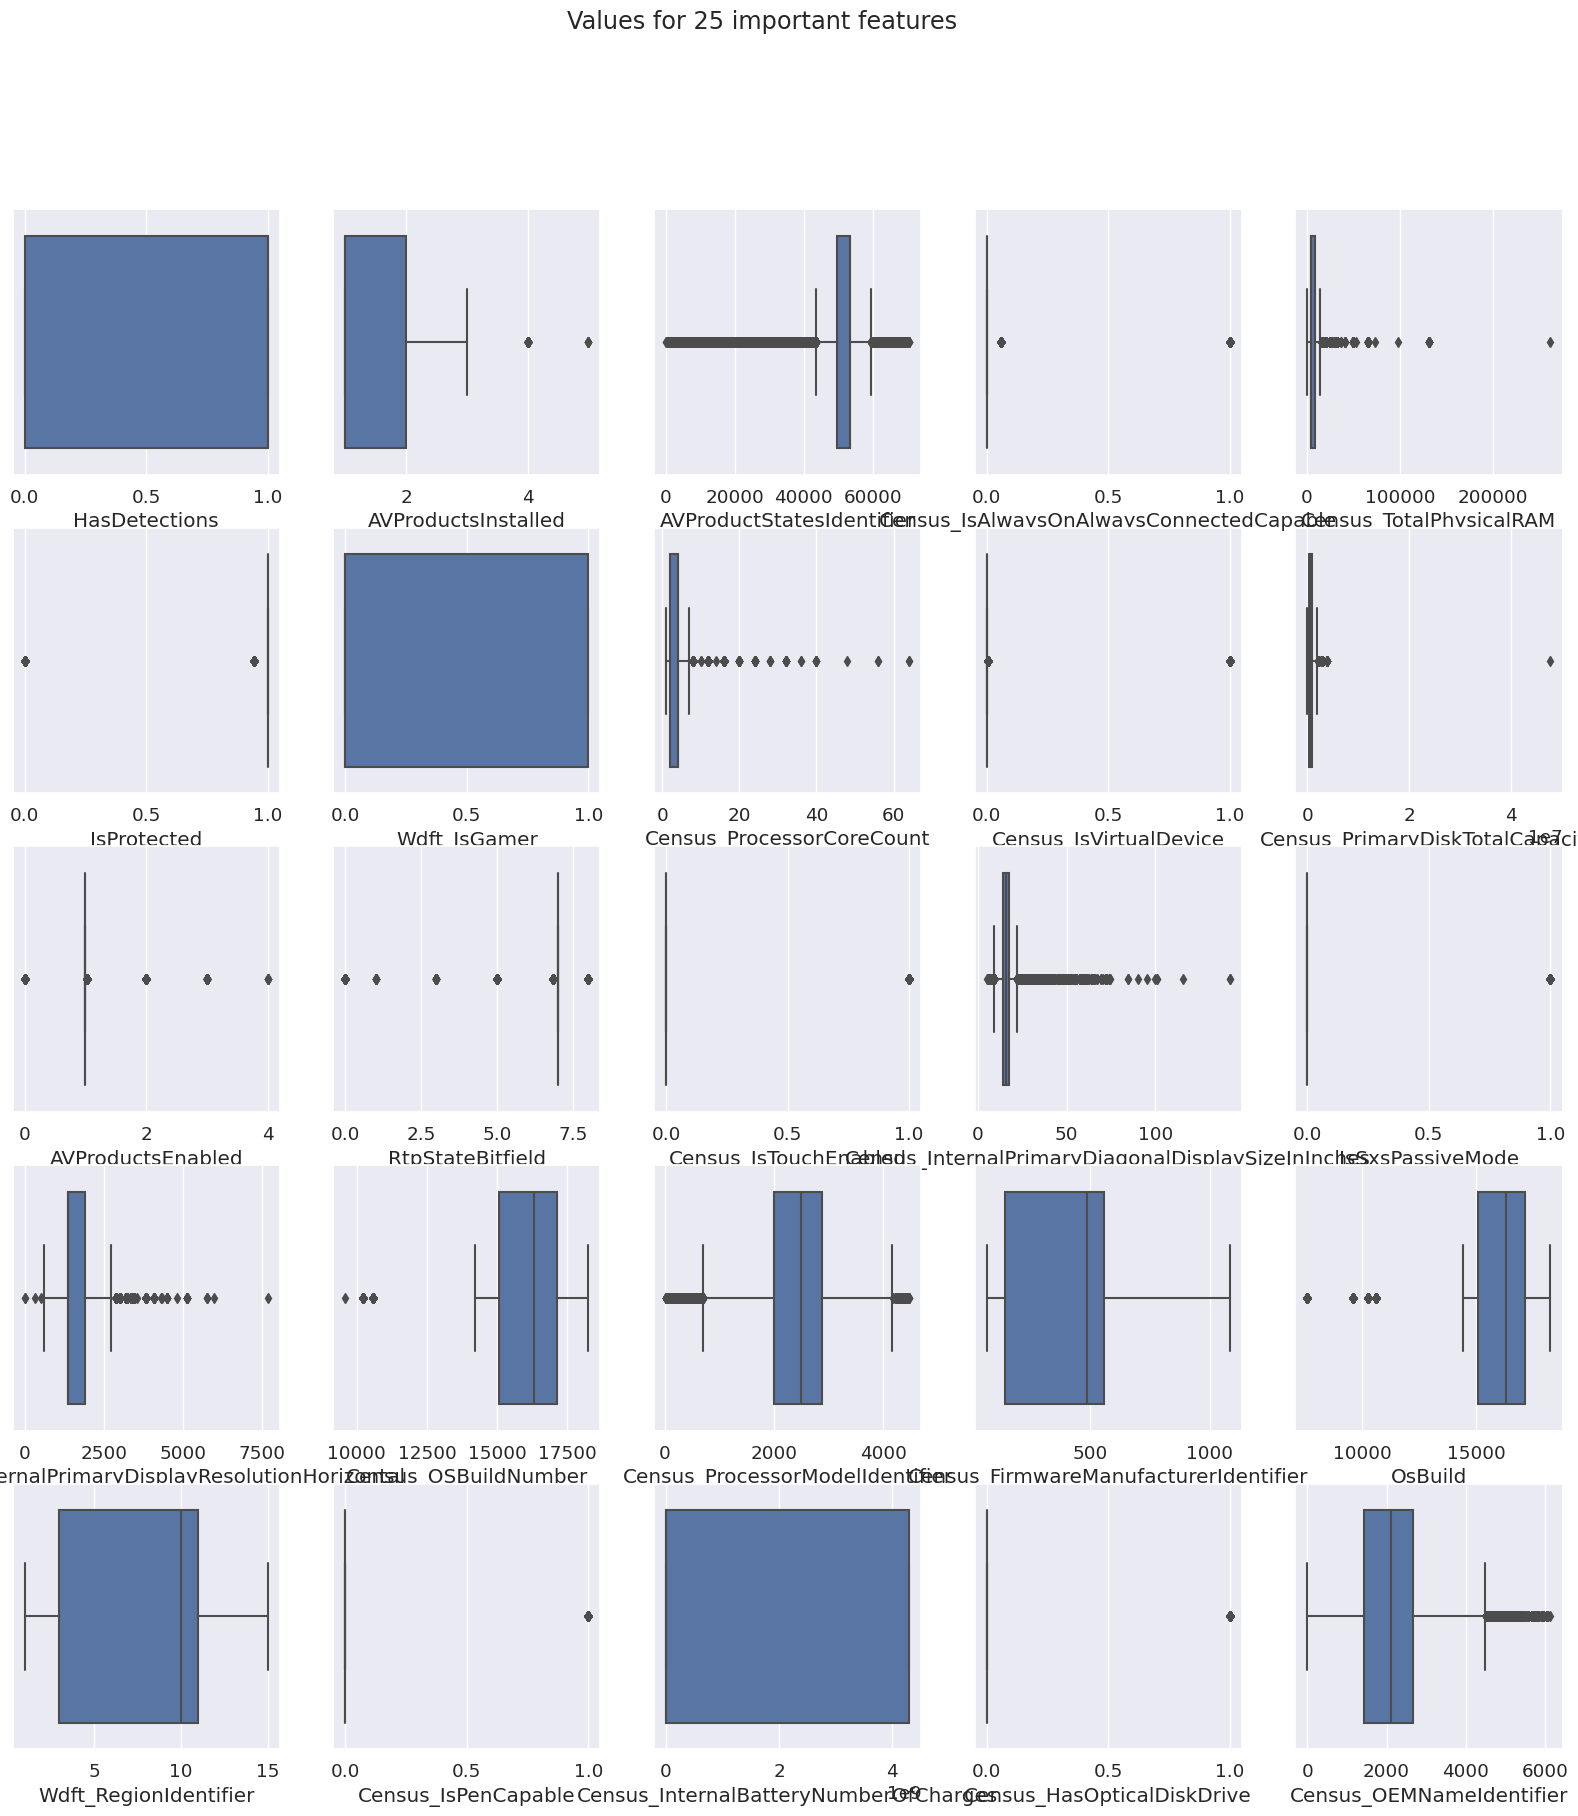

In [23]:
plt.figure(figsize=(20,20))
for i in range(len(cols[:25])):
    plt.subplot(5,5, i+1) 
    sns.boxplot(x=df_train[cols[i]])
plt.suptitle('Values for 25 important features')

In [24]:
df_unique = df_train.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
# df_unique.head(50)

In [25]:
# df_unique.loc[(df_unique['DistinctCount']<10 )& (df_unique['Variable'].apply(lambda x: x in cat_columns))]

In [26]:
df_unique.loc[df_unique['Variable'].apply(lambda x: x in cat_columns)]

,Variable,DistinctCount
0,ProductName,4
1,EngineVersion,44
2,AppVersion,78
3,AvSigVersion,4003
15,Platform,4
16,Processor,3
17,OsVer,6
20,OsPlatformSubRelease,9
21,OsBuildLab,365
22,SkuEdition,8


In [27]:
# print(df_train['ProductName'].unique())
print(df_train['ProductName'].value_counts())
print((df_train['ProductName'].value_counts()*100)/2000000)
# this plot shows that the data variation in this column is skewed. this column must be dropped.

win8defender     98959
mse               1039
mseprerelease        1
scep                 1
Name: ProductName, dtype: int64
win8defender     4.94795
mse              0.05195
mseprerelease    0.00005
scep             0.00005
Name: ProductName, dtype: float64


In [28]:
print((df_train['EngineVersion'].value_counts()*100)/2000000)

1.1.15200.1    2.14275
1.1.15100.1    2.06305
1.1.15000.2    0.15290
1.1.14901.4    0.12140
1.1.14600.4    0.09355
1.1.14800.3    0.07670
1.1.15300.6    0.06555
1.1.14104.0    0.05300
1.1.13504.0    0.03880
1.1.15300.5    0.03770
1.1.14500.5    0.02655
1.1.14700.5    0.02450
1.1.14405.2    0.02145
1.1.14306.0    0.01340
1.1.14202.0    0.00915
1.1.14003.0    0.00705
1.1.13903.0    0.00610
1.1.13804.0    0.00580
1.1.13407.0    0.00530
1.1.13303.0    0.00525
1.1.13601.0    0.00425
1.1.12902.0    0.00330
1.1.13202.0    0.00300
1.1.13701.0    0.00285
1.1.13704.0    0.00270
1.1.13103.0    0.00265
1.1.14305.0    0.00245
1.1.13000.0    0.00200
1.1.15000.1    0.00140
1.1.12805.0    0.00135
1.1.14901.3    0.00120
1.1.14800.1    0.00065
1.1.14700.4    0.00060
1.1.14700.3    0.00040
1.1.14500.2    0.00025
1.1.11701.0    0.00020
1.1.14201.0    0.00015
1.1.13902.0    0.00015
1.1.13803.0    0.00010
1.1.14303.0    0.00010
1.1.9700.0     0.00010
1.1.12101.0    0.00010
1.1.14103.0    0.00005
1.1.12804.0

In [29]:
#change the value which is less tha 10% to other
value_counts = df_train['EngineVersion'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['EngineVersion'].isin(value_counts[mask].index), 'EngineVersion'] = 'Other'
df_test.loc[df_test['EngineVersion'].isin(value_counts[mask].index), 'EngineVersion'] = 'Other'
print((df_train['EngineVersion'].value_counts()*100)/2000000)

1.1.15200.1    2.14275
1.1.15100.1    2.06305
Other          0.79420
Name: EngineVersion, dtype: float64


<AxesSubplot: >

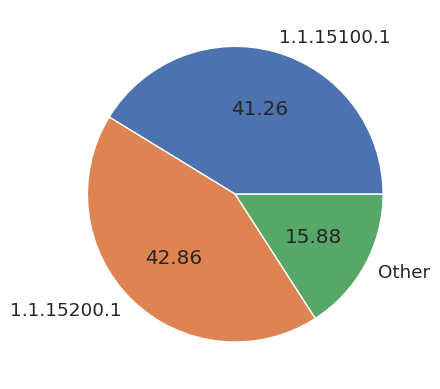

In [30]:
df_train.groupby('EngineVersion').size().plot(kind='pie', autopct='%.2f')

In [31]:
print((df_train['AppVersion'].value_counts()*100)/2000000)

4.18.1807.18075     2.88680
4.18.1806.18062     0.47580
4.12.16299.15       0.20165
4.13.17134.1        0.14665
4.10.209.0          0.14490
                     ...   
4.10.14393.1532     0.00005
4.17.17685.20082    0.00005
4.17.17672.1000     0.00005
4.17.17682.1000     0.00005
4.8.10240.17770     0.00005
Name: AppVersion, Length: 78, dtype: float64


In [32]:
#change the value which is less tha 10% to other
value_counts = df_train['AppVersion'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['AppVersion'].isin(value_counts[mask].index), 'AppVersion'] = 'Other'
df_test.loc[df_test['AppVersion'].isin(value_counts[mask].index), 'AppVersion'] = 'Other'
print((df_train['AppVersion'].value_counts()*100)/2000000)

4.18.1807.18075    2.8868
Other              2.1132
Name: AppVersion, dtype: float64


<AxesSubplot: >

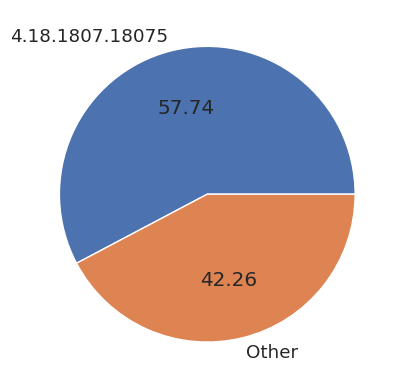

In [33]:
df_train.groupby('AppVersion').size().plot(kind='pie', autopct='%.2f')

In [34]:
print((df_train['AvSigVersion'].value_counts()*100)/2000000)
#data shows that 8k different value and its string data
# dont know may be delete this

1.273.1420.0    0.05800
1.263.48.0      0.05770
1.275.1140.0    0.05370
1.275.727.0     0.04940
1.273.371.0     0.04855
                 ...   
1.243.1021.0    0.00005
1.257.225.0     0.00005
1.263.321.0     0.00005
1.235.754.0     0.00005
1.235.476.0     0.00005
Name: AvSigVersion, Length: 4003, dtype: float64


In [35]:
print((df_train['Platform'].value_counts()*100)/2000000)
#data is skewed must delete

windows10      4.8384
windows8       0.1027
windows7       0.0515
windows2016    0.0074
Name: Platform, dtype: float64


In [36]:
print((df_train['Processor'].value_counts()*100)/2000000)
#data is skewed must delete

x64      4.53895
x86      0.46060
arm64    0.00045
Name: Processor, dtype: float64


In [37]:
print((df_train['OsVer'].value_counts()*100)/2000000)
#data is skewed must delete

10.0.0.0    4.84560
6.3.0.0     0.10270
6.1.1.0     0.05115
6.1.0.0     0.00035
10.0.1.0    0.00010
10.0.3.0    0.00010
Name: OsVer, dtype: float64


In [38]:
print((df_train['OsPlatformSubRelease'].value_counts()*100)/2000000)

rs4           2.19555
rs3           1.40550
rs2           0.43845
rs1           0.41245
th2           0.23310
th1           0.14860
windows8.1    0.10270
windows7      0.05150
prers5        0.01215
Name: OsPlatformSubRelease, dtype: float64


In [39]:
#change the value which is less tha 10% to other
value_counts = df_train['OsPlatformSubRelease'].value_counts(normalize=True)
mask = value_counts < 0.05
df_train.loc[df_train['OsPlatformSubRelease'].isin(value_counts[mask].index), 'OsPlatformSubRelease'] = 'Other'
df_test.loc[df_test['OsPlatformSubRelease'].isin(value_counts[mask].index), 'OsPlatformSubRelease'] = 'Other'

print((df_train['OsPlatformSubRelease'].value_counts()*100)/2000000)

rs4      2.19555
rs3      1.40550
Other    0.54805
rs2      0.43845
rs1      0.41245
Name: OsPlatformSubRelease, dtype: float64


<AxesSubplot: >

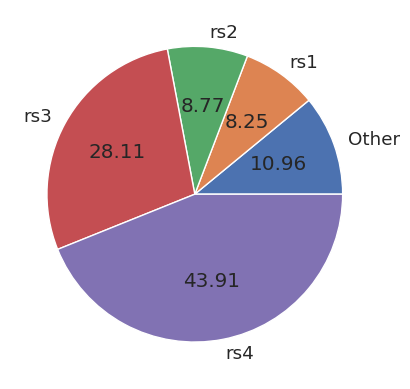

In [40]:
df_train.groupby('OsPlatformSubRelease').size().plot(kind='pie', autopct='%.2f')

In [41]:
print((df_train['OsBuildLab'].value_counts()*100)/2000000)

17134.1.amd64fre.rs4_release.180410-1804                 2.04895
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.70470
16299.15.amd64fre.rs3_release.170928-1534                0.53850
15063.0.amd64fre.rs2_release.170317-1834                 0.40305
17134.1.x86fre.rs4_release.180410-1804                   0.14630
                                                          ...   
7601.23807.x86fre.win7sp1_ldr.170512-0600                0.00005
14393.2457.x86fre.rs1_release_inmarket.180822-1743       0.00005
9600.17668.amd64fre.winblue_r8.150127-1500               0.00005
14393.2339.x86fre.rs1_release_inmarket.180611-1502       0.00005
10240.17770.amd64fre.th1.180209-1728                     0.00005
Name: OsBuildLab, Length: 365, dtype: float64


In [42]:
#change the value which is less tha 10% to other
value_counts = df_train['OsBuildLab'].value_counts(normalize=True)
mask = value_counts < 0.05
df_train.loc[df_train['OsBuildLab'].isin(value_counts[mask].index), 'OsBuildLab'] = 'Other'
df_test.loc[df_test['OsBuildLab'].isin(value_counts[mask].index), 'OsBuildLab'] = 'Other'
print((df_train['OsBuildLab'].value_counts()*100)/2000000)

17134.1.amd64fre.rs4_release.180410-1804                 2.04895
Other                                                    1.30480
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    0.70470
16299.15.amd64fre.rs3_release.170928-1534                0.53850
15063.0.amd64fre.rs2_release.170317-1834                 0.40305
Name: OsBuildLab, dtype: float64


<AxesSubplot: >

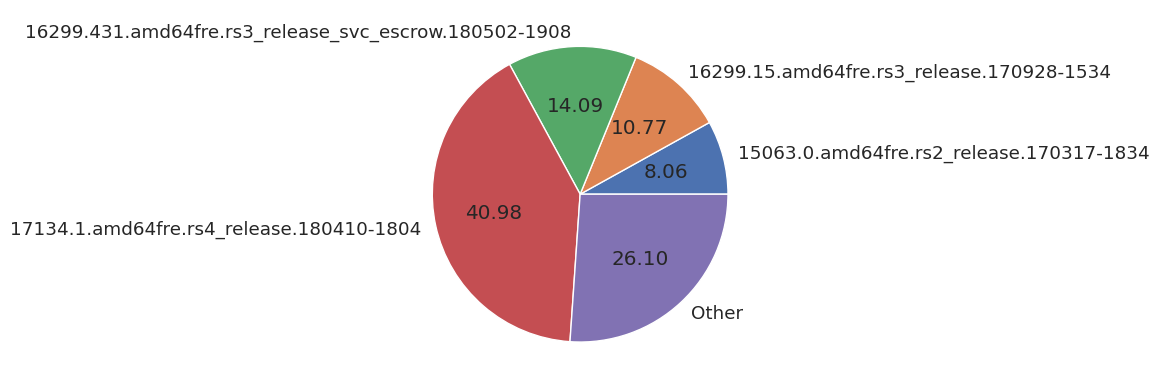

In [43]:
df_train.groupby('OsBuildLab').size().plot(kind='pie', autopct='%.2f')

In [44]:
print((df_train['SkuEdition'].value_counts()*100)/2000000)

Home               3.09140
Pro                1.80770
Invalid            0.04320
Education          0.02160
Enterprise         0.01965
Enterprise LTSB    0.01120
Cloud              0.00325
Server             0.00200
Name: SkuEdition, dtype: float64


In [45]:
#change the value which is less tha 10% to other
value_counts = df_train['SkuEdition'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['SkuEdition'].isin(value_counts[mask].index), 'SkuEdition'] = 'Other'
df_test.loc[df_test['SkuEdition'].isin(value_counts[mask].index), 'SkuEdition'] = 'Other'

print((df_train['SkuEdition'].value_counts()*100)/2000000)

Home     3.0914
Pro      1.8077
Other    0.1009
Name: SkuEdition, dtype: float64


<AxesSubplot: >

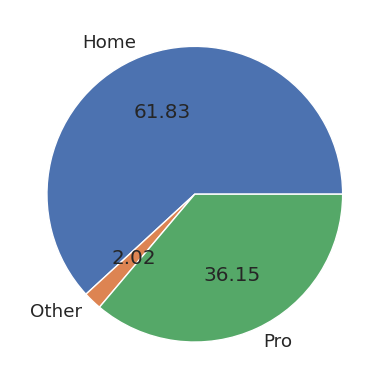

In [46]:
df_train.groupby('SkuEdition').size().plot(kind='pie', autopct='%.2f')

In [47]:
print((df_train['Census_MDC2FormFactor'].value_counts()*100)/2000000)

Notebook        3.21140
Desktop         1.08575
Convertible     0.22765
Detachable      0.17035
AllInOne        0.16430
PCOther         0.07980
LargeTablet     0.03695
SmallTablet     0.01755
SmallServer     0.00425
MediumServer    0.00155
LargeServer     0.00045
Name: Census_MDC2FormFactor, dtype: float64


In [48]:
#change the value which is less tha 10% to other
value_counts = df_train['Census_MDC2FormFactor'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['Census_MDC2FormFactor'].isin(value_counts[mask].index), 'Census_MDC2FormFactor'] = 'Other'
df_test.loc[df_test['Census_MDC2FormFactor'].isin(value_counts[mask].index), 'Census_MDC2FormFactor'] = 'Other'
print((df_train['Census_MDC2FormFactor'].value_counts()*100)/2000000)

Notebook    3.21140
Desktop     1.08575
Other       0.70285
Name: Census_MDC2FormFactor, dtype: float64


<AxesSubplot: >

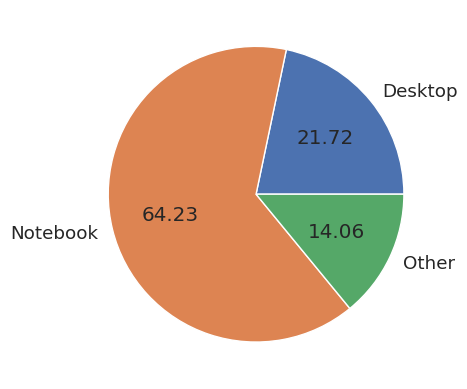

In [49]:
df_train.groupby('Census_MDC2FormFactor').size().plot(kind='pie', autopct='%.2f')

In [50]:
print((df_train['Census_DeviceFamily'].value_counts()*100)/2000000)

#data is skewed must delete the column

Windows.Desktop    4.99250
Windows.Server     0.00745
Windows            0.00005
Name: Census_DeviceFamily, dtype: float64


In [51]:
print((df_train['Census_PrimaryDiskTypeName'].value_counts()*100)/2000000)

HDD            3.25260
SSD            1.39160
UNKNOWN        0.19945
Unspecified    0.15635
Name: Census_PrimaryDiskTypeName, dtype: float64


In [52]:
#change the value which is less tha 10% to other
value_counts = df_train['Census_PrimaryDiskTypeName'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['Census_PrimaryDiskTypeName'].isin(value_counts[mask].index), 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'
df_test.loc[df_test['Census_PrimaryDiskTypeName'].isin(value_counts[mask].index), 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'
print((df_train['Census_PrimaryDiskTypeName'].value_counts()*100)/2000000)

HDD        3.2526
SSD        1.3916
UNKNOWN    0.3558
Name: Census_PrimaryDiskTypeName, dtype: float64


<AxesSubplot: >

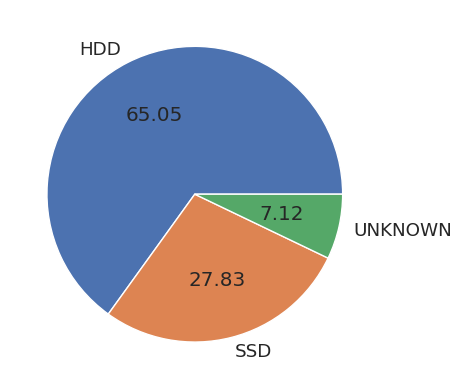

In [53]:
df_train.groupby('Census_PrimaryDiskTypeName').size().plot(kind='pie', autopct='%.2f')

In [54]:
print((df_train['Census_ChassisTypeName'].value_counts()*100)/2000000)

Notebook               2.93835
Desktop                1.04755
Laptop                 0.38875
Portable               0.20225
AllinOne               0.11720
MiniTower              0.04785
Convertible            0.04690
Other                  0.04110
UNKNOWN                0.04095
Detachable             0.02845
LowProfileDesktop      0.02780
HandHeld               0.02695
SpaceSaving            0.01465
Tablet                 0.00790
Tower                  0.00635
Unknown                0.00455
MainServerChassis      0.00420
MiniPC                 0.00310
LunchBox               0.00205
RackMountChassis       0.00165
BusExpansionChassis    0.00040
SubNotebook            0.00040
PizzaBox               0.00010
30                     0.00010
SubChassis             0.00010
StickPC                0.00010
MultisystemChassis     0.00005
SealedCasePC           0.00005
127                    0.00005
25                     0.00005
0                      0.00005
Name: Census_ChassisTypeName, dtype: fl

In [55]:
#change the value which is less tha 1% to other
value_counts = df_train['Census_ChassisTypeName'].value_counts(normalize=True)
mask = value_counts < 0.01
df_train.loc[df_train['Census_ChassisTypeName'].isin(value_counts[mask].index), 'Census_ChassisTypeName'] = 'Other'
df_test.loc[df_test['Census_ChassisTypeName'].isin(value_counts[mask].index), 'Census_ChassisTypeName'] = 'Other'

print((df_train['Census_ChassisTypeName'].value_counts()*100)/2000000)

Notebook    2.93835
Desktop     1.04755
Laptop      0.38875
Other       0.30590
Portable    0.20225
AllinOne    0.11720
Name: Census_ChassisTypeName, dtype: float64


<AxesSubplot: >

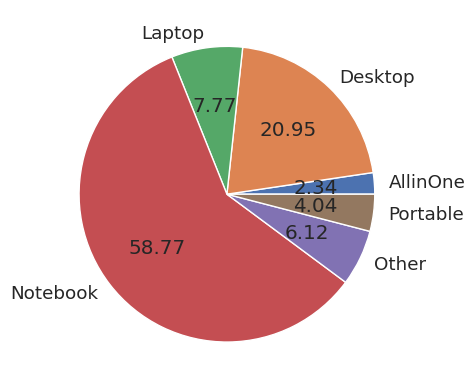

In [56]:
df_train.groupby('Census_ChassisTypeName').size().plot(kind='pie', autopct='%.2f')

In [57]:
print((df_train['Census_PowerPlatformRoleName'].value_counts()*100)/2000000)

Mobile               3.47020
Desktop              1.15555
Slate                0.27565
Workstation          0.06230
SOHOServer           0.01900
UNKNOWN              0.01215
EnterpriseServer     0.00310
AppliancePC          0.00200
PerformanceServer    0.00005
Name: Census_PowerPlatformRoleName, dtype: float64


In [58]:
#change the value which is less tha 10% to other
value_counts = df_train['Census_PowerPlatformRoleName'].value_counts(normalize=True)
mask = value_counts < 0.1
df_train.loc[df_train['Census_PowerPlatformRoleName'].isin(value_counts[mask].index), 'Census_PowerPlatformRoleName'] = 'Other'
df_test.loc[df_test['Census_PowerPlatformRoleName'].isin(value_counts[mask].index), 'Census_PowerPlatformRoleName'] = 'Other'

print((df_train['Census_PowerPlatformRoleName'].value_counts()*100)/2000000)

Mobile     3.47020
Desktop    1.15555
Other      0.37425
Name: Census_PowerPlatformRoleName, dtype: float64


<AxesSubplot: >

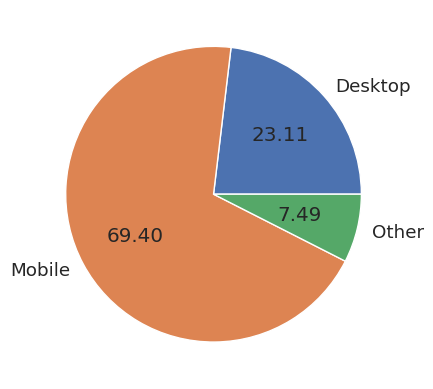

In [59]:
df_train.groupby('Census_PowerPlatformRoleName').size().plot(kind='pie', autopct='%.2f')

In [60]:
print((df_train['Census_OSVersion'].value_counts()*100)/2000000)

10.0.17134.228     0.79150
10.0.17134.165     0.50495
10.0.16299.431     0.30560
10.0.17134.285     0.26360
10.0.17134.112     0.19605
                    ...   
10.0.10586.639     0.00005
10.0.17711.1000    0.00005
10.0.15063.242     0.00005
10.0.14206.228     0.00005
10.0.14393.1613    0.00005
Name: Census_OSVersion, Length: 262, dtype: float64


In [61]:
#change the value which is less tha 3% to other
value_counts = df_train['Census_OSVersion'].value_counts(normalize=True)
mask = value_counts < 0.03
df_train.loc[df_train['Census_OSVersion'].isin(value_counts[mask].index), 'Census_OSVersion'] = 'Other'
print((df_train['Census_OSVersion'].value_counts()*100)/2000000)

# too much variation for categorical value must delete

Other             2.56415
10.0.17134.228    0.79150
10.0.17134.165    0.50495
10.0.16299.431    0.30560
10.0.17134.285    0.26360
10.0.17134.112    0.19605
10.0.16299.547    0.19065
10.0.16299.371    0.18350
Name: Census_OSVersion, dtype: float64


In [62]:
print((df_train['Census_OSArchitecture'].value_counts()*100)/2000000)
#data is skewed must delete

amd64    4.53955
x86      0.46000
arm64    0.00045
Name: Census_OSArchitecture, dtype: float64


In [63]:
print((df_train['Census_OSBranch'].value_counts()*100)/2000000)

rs4_release                  2.24655
rs3_release                  0.69170
rs3_release_svc_escrow       0.67675
rs2_release                  0.44810
rs1_release                  0.44310
th2_release                  0.18160
th2_release_sec              0.14780
th1_st1                      0.10780
th1                          0.04100
rs5_release                  0.00915
rs3_release_svc_escrow_im    0.00300
rs_prerelease                0.00185
rs_prerelease_flt            0.00155
winblue_ltsb_escrow          0.00005
Name: Census_OSBranch, dtype: float64


In [64]:
#change the value which is less tha 5% to other
value_counts = df_train['Census_OSBranch'].value_counts(normalize=True)
mask = value_counts < 0.05
df_train.loc[df_train['Census_OSBranch'].isin(value_counts[mask].index), 'Census_OSBranch'] = 'Other'
df_test.loc[df_test['Census_OSBranch'].isin(value_counts[mask].index), 'Census_OSBranch'] = 'Other'

print((df_train['Census_OSBranch'].value_counts()*100)/2000000)

rs4_release               2.24655
rs3_release               0.69170
rs3_release_svc_escrow    0.67675
Other                     0.49380
rs2_release               0.44810
rs1_release               0.44310
Name: Census_OSBranch, dtype: float64


<AxesSubplot: >

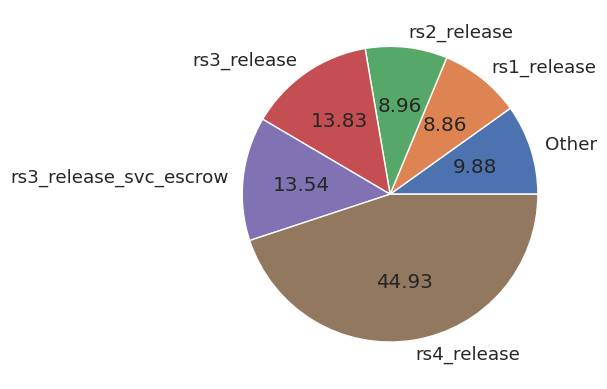

In [65]:
df_train.groupby('Census_OSBranch').size().plot(kind='pie', autopct='%.2f')

In [66]:
print((df_train['Census_OSEdition'].value_counts()*100)/2000000)

Core                      1.94430
Professional              1.75345
CoreSingleLanguage        1.09090
CoreCountrySpecific       0.09315
ProfessionalEducation     0.03365
Education                 0.02115
Enterprise                0.02040
ProfessionalN             0.01720
EnterpriseS               0.01115
ServerStandard            0.00520
Cloud                     0.00335
CoreN                     0.00230
ServerStandardEval        0.00170
EducationN                0.00080
EnterpriseSN              0.00045
ServerDatacenterEval      0.00030
ServerSolution            0.00025
EnterpriseN               0.00025
ProfessionalEducationN    0.00005
Name: Census_OSEdition, dtype: float64


In [67]:
#change the value which is less tha 10% to other
value_counts = df_train['Census_OSEdition'].value_counts(normalize=True)
mask = value_counts < 0.10
df_train.loc[df_train['Census_OSEdition'].isin(value_counts[mask].index), 'Census_OSEdition'] = 'Other'
df_test.loc[df_test['Census_OSEdition'].isin(value_counts[mask].index), 'Census_OSEdition'] = 'Other'
print((df_train['Census_OSEdition'].value_counts()*100)/2000000)

Core                  1.94430
Professional          1.75345
CoreSingleLanguage    1.09090
Other                 0.21135
Name: Census_OSEdition, dtype: float64


<AxesSubplot: >

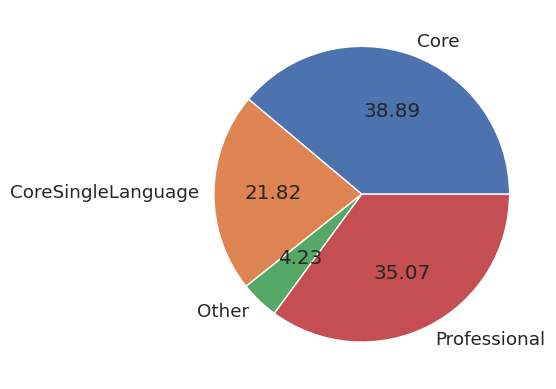

In [68]:
df_train.groupby('Census_OSEdition').size().plot(kind='pie', autopct='%.2f')

In [69]:
print((df_train['Census_OSSkuName'].value_counts()*100)/2000000)

CORE                            1.94410
PROFESSIONAL                    1.78750
CORE_SINGLELANGUAGE             1.09070
CORE_COUNTRYSPECIFIC            0.09305
EDUCATION                       0.02130
ENTERPRISE                      0.02040
PROFESSIONAL_N                  0.01725
ENTERPRISE_S                    0.01115
STANDARD_SERVER                 0.00520
CLOUD                           0.00330
CORE_N                          0.00230
STANDARD_EVALUATION_SERVER      0.00170
EDUCATION_N                     0.00080
ENTERPRISE_S_N                  0.00045
DATACENTER_EVALUATION_SERVER    0.00030
SB_SOLUTION_SERVER              0.00025
ENTERPRISE_N                    0.00025
Name: Census_OSSkuName, dtype: float64


In [70]:
#change the value which is less tha 10% to other
value_counts = df_train['Census_OSSkuName'].value_counts(normalize=True)
mask = value_counts < 0.10
df_train.loc[df_train['Census_OSSkuName'].isin(value_counts[mask].index), 'Census_OSSkuName'] = 'Other'
df_test.loc[df_test['Census_OSSkuName'].isin(value_counts[mask].index), 'Census_OSSkuName'] = 'Other'

print((df_train['Census_OSSkuName'].value_counts()*100)/2000000)

CORE                   1.9441
PROFESSIONAL           1.7875
CORE_SINGLELANGUAGE    1.0907
Other                  0.1777
Name: Census_OSSkuName, dtype: float64


<AxesSubplot: >

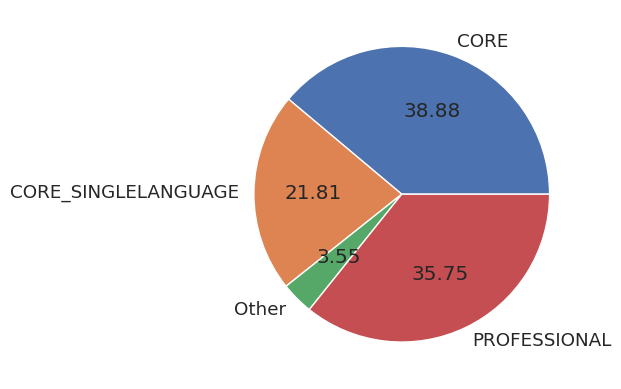

In [71]:
df_train.groupby('Census_OSSkuName').size().plot(kind='pie', autopct='%.2f')

In [72]:
print((df_train['Census_OSInstallTypeName'].value_counts()*100)/2000000)

UUPUpgrade        1.46745
IBSClean          0.92620
Update            0.88530
Upgrade           0.69340
Other             0.47740
Reset             0.36395
Refresh           0.11685
Clean             0.03850
CleanPCRefresh    0.03095
Name: Census_OSInstallTypeName, dtype: float64


<AxesSubplot: >

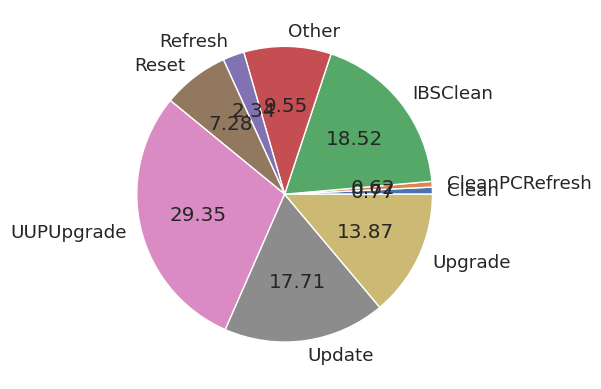

In [73]:
df_train.groupby('Census_OSInstallTypeName').size().plot(kind='pie', autopct='%.2f')

In [74]:
print((df_train['Census_OSWUAutoUpdateOptionsName'].value_counts()*100)/2000000)

FullAuto                                 2.20905
UNKNOWN                                  1.42000
Notify                                   1.14405
AutoInstallAndRebootAtMaintenanceTime    0.20675
Off                                      0.01275
DownloadNotify                           0.00740
Name: Census_OSWUAutoUpdateOptionsName, dtype: float64


<AxesSubplot: >

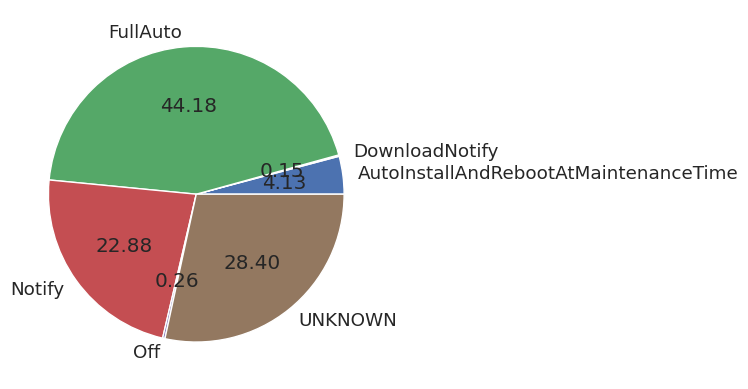

In [75]:
df_train.groupby('Census_OSWUAutoUpdateOptionsName').size().plot(kind='pie', autopct='%.2f')

In [76]:
print((df_train['Census_GenuineStateName'].value_counts()*100)/2000000)
#data is skewed must delete

IS_GENUINE         4.40820
INVALID_LICENSE    0.45375
OFFLINE            0.13025
UNKNOWN            0.00780
Name: Census_GenuineStateName, dtype: float64


In [77]:
print((df_train['Census_ActivationChannel'].value_counts()*100)/2000000)

Retail            2.64630
OEM:DM            1.92515
Volume:GVLK       0.24720
OEM:NONSLP        0.17510
Volume:MAK        0.00425
Retail:TB:Eval    0.00200
Name: Census_ActivationChannel, dtype: float64


<AxesSubplot: >

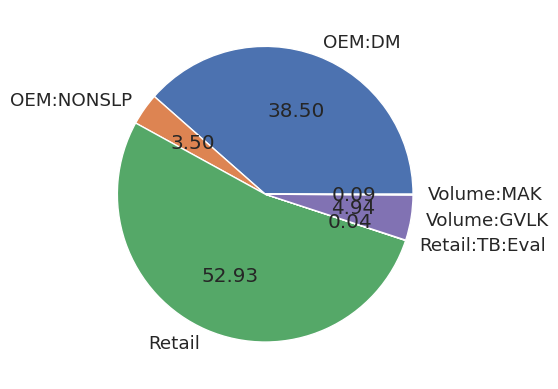

In [78]:
df_train.groupby('Census_ActivationChannel').size().plot(kind='pie', autopct='%.2f')

In [79]:
print((df_train['Census_FlightRing'].value_counts()*100)/2000000)

# data is skewed must delete

Retail      4.68495
NOT_SET     0.15885
Unknown     0.13605
WIS         0.00640
WIF         0.00605
RP          0.00590
Disabled    0.00180
Name: Census_FlightRing, dtype: float64


In [80]:
# ProductName,Processor, OsVer, Census_DeviceFamily, Census_OSArchitecture, Census_GenuineStateName, Census_FlightRing
# all of these columns data is skewed.
# must delete this
# "AvSigVersion","Census_OSVersion"
df_train.drop(columns=['ProductName','Processor', 'OsVer', 'Census_DeviceFamily', 'Census_OSArchitecture', 'Census_GenuineStateName', 'Census_FlightRing'],inplace=True)
df_test.drop(columns=['ProductName','Processor', 'OsVer', 'Census_DeviceFamily', 'Census_OSArchitecture', 'Census_GenuineStateName', 'Census_FlightRing'],inplace=True) 

In [81]:

# all of these columns have too many data for a categorical type
# must delete this
df_train.drop(columns=['AvSigVersion','Census_OSVersion'],inplace=True)
df_test.drop(columns=['AvSigVersion','Census_OSVersion',],inplace=True)

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 5399222 to 278996
Data columns (total 63 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   EngineVersion                                      100000 non-null  object 
 1   AppVersion                                         100000 non-null  object 
 2   IsBeta                                             100000 non-null  int64  
 3   RtpStateBitfield                                   100000 non-null  float64
 4   IsSxsPassiveMode                                   100000 non-null  int64  
 5   AVProductStatesIdentifier                          100000 non-null  float64
 6   AVProductsInstalled                                100000 non-null  float64
 7   AVProductsEnabled                                  100000 non-null  float64
 8   HasTpm                                             100000 non-null  

one hot encoding

In [83]:
dtypes = df_train.dtypes
numerics = [ 'int64', 'float64']
num_columns = [c for c,v in dtypes.items() if v in numerics]
cat_columns = [c for c,v in dtypes.items() if v not in numerics]

print("Numerical Column : ",len(num_columns),"\n")
print(num_columns)
print("\n\nCategorical Column",len(cat_columns),"\n")
print(cat_columns)


Numerical Column :  47 

['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_IsPortableOperatingSystem', 'Ce

In [84]:
one_hot_encoded_data = pd.get_dummies(df_train, columns = ['EngineVersion', 'AppVersion', 'Platform', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel'])
one_hot_encoded_test_data = pd.get_dummies(df_test, columns = ['EngineVersion', 'AppVersion', 'Platform', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel'])

one_hot_encoded_data

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_1.1.15100.1,EngineVersion_1.1.15200.1,EngineVersion_Other,AppVersion_4.18.1807.18075,AppVersion_Other,Platform_windows10,Platform_windows2016,Platform_windows7,Platform_windows8,OsPlatformSubRelease_Other,OsPlatformSubRelease_rs1,OsPlatformSubRelease_rs2,OsPlatformSubRelease_rs3,OsPlatformSubRelease_rs4,OsBuildLab_15063.0.amd64fre.rs2_release.170317-1834,OsBuildLab_16299.15.amd64fre.rs3_release.170928-1534,OsBuildLab_16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,OsBuildLab_17134.1.amd64fre.rs4_release.180410-1804,OsBuildLab_Other,SkuEdition_Home,SkuEdition_Other,SkuEdition_Pro,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Other,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_ChassisTypeName_AllinOne,Census_ChassisTypeName_Desktop,Census_ChassisTypeName_Laptop,Census_ChassisTypeName_Notebook,Census_ChassisTypeName_Other,Census_ChassisTypeName_Portable,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Other,Census_OSBranch_Other,Census_OSBranch_rs1_release,Census_OSBranch_rs2_release,Census_OSBranch_rs3_release,Census_OSBranch_rs3_release_svc_escrow,Census_OSBranch_rs4_release,Census_OSEdition_Core,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_Other,Census_OSEdition_Professional,Census_OSSkuName_CORE,Census_OSSkuName_CORE_SINGLELANGUAGE,Census_OSSkuName_Other,Census_OSSkuName_PROFESSIONAL,Census_OSInstallTypeName_Clean,Census_OSInstallTypeName_CleanPCRefresh,Census_OSInstallTypeName_IBSClean,Census_OSInstallTypeName_Other,Census_OSInstallTypeName_Refresh,Census_OSInstallTypeName_Reset,Census_OSInstallTypeName_UUPUpgrade,Census_OSInstallTypeName_Update,Census_OSInstallTypeName_Upgrade,Census_OSWUAutoUpdateOptionsName_AutoInstallAndRebootAtMaintenanceTime,Census_OSWUAutoUpdateOptionsName_DownloadNotify,Census_OSWUAutoUpdateOptionsName_FullAuto,Census_OSWUAutoUpdateOptionsName_Notify,Census_OSWUAutoUpdateOptionsName_Off,Census_OSWUAutoUpdateOptionsName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_OEM:NONSLP,Census_ActivationChannel_Retail,Census_ActivationChannel_Retail:TB:Eval,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK
5399222,0,7.0,0,53447.0,1.0,1.0,1,189,111332.0,277.0,75,17134,256,1.0,0,137.0,1.0,1.0,2102.0,249154.0,4.0,5.0,2412.0,122104.0,120635.0,0,4096.0,15.5,1920.0,1080.0,0.000000e+00,17134,285,7.0,30,0,0.0,486.0,56002.0,1,0.0,0,0,0.0,1.0,10.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4419811,0,7.0,0,61454.0,2.0,2.0,1,141,56206.0,167.0,227,14393,768,0.0,0,96.0,1.0,1.0,4730.0,311992.0,4.0,5.0,2257.0,476940.0,474988.0,0,3072.0,14.0,1366.0,768.0,5.200000e+01,14393,1715,9.0,34,0,0.0,512.

Model Traning

In [85]:
# from keras import callbacks
# from sklearn.metrics import roc_auc_score

   

class printAUC(callbacks.Callback):
    def __init__(self, X_train, y_train, validation_data):
        super(printAUC, self).__init__()
        self.bestAUC = 0
        self.X_train = X_train
        self.y_train = y_train
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(np.array(self.X_train))
        auc = roc_auc_score(self.y_train, pred)
        print("Train AUC: " + str(auc))
        pred = self.model.predict(self.validation_data[0])
        auc = roc_auc_score(self.validation_data[1], pred)
        print ("Validation AUC: " + str(auc))
        if (self.bestAUC < auc) :
            self.bestAUC = auc
            self.model.save("bestNet.h5", overwrite=True)
        return



In [86]:
# from sklearn.model_selection import train_test_split
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization, Activation
# from keras.callbacks import LearningRateScheduler
# from keras.optimizers import Adam

In [87]:
#SPLIT TRAIN AND VALIDATION SET
X=one_hot_encoded_data.loc[:, one_hot_encoded_data.columns != 'HasDetections']
y= one_hot_encoded_data['HasDetections']

In [88]:
one_hot_encoded_data.shape,X.shape, y.shape

((100000, 119), (100000, 118), (100000,))

In [89]:
X

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1.1.15100.1,EngineVersion_1.1.15200.1,EngineVersion_Other,AppVersion_4.18.1807.18075,AppVersion_Other,Platform_windows10,Platform_windows2016,Platform_windows7,Platform_windows8,OsPlatformSubRelease_Other,OsPlatformSubRelease_rs1,OsPlatformSubRelease_rs2,OsPlatformSubRelease_rs3,OsPlatformSubRelease_rs4,OsBuildLab_15063.0.amd64fre.rs2_release.170317-1834,OsBuildLab_16299.15.amd64fre.rs3_release.170928-1534,OsBuildLab_16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,OsBuildLab_17134.1.amd64fre.rs4_release.180410-1804,OsBuildLab_Other,SkuEdition_Home,SkuEdition_Other,SkuEdition_Pro,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Other,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_ChassisTypeName_AllinOne,Census_ChassisTypeName_Desktop,Census_ChassisTypeName_Laptop,Census_ChassisTypeName_Notebook,Census_ChassisTypeName_Other,Census_ChassisTypeName_Portable,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Other,Census_OSBranch_Other,Census_OSBranch_rs1_release,Census_OSBranch_rs2_release,Census_OSBranch_rs3_release,Census_OSBranch_rs3_release_svc_escrow,Census_OSBranch_rs4_release,Census_OSEdition_Core,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_Other,Census_OSEdition_Professional,Census_OSSkuName_CORE,Census_OSSkuName_CORE_SINGLELANGUAGE,Census_OSSkuName_Other,Census_OSSkuName_PROFESSIONAL,Census_OSInstallTypeName_Clean,Census_OSInstallTypeName_CleanPCRefresh,Census_OSInstallTypeName_IBSClean,Census_OSInstallTypeName_Other,Census_OSInstallTypeName_Refresh,Census_OSInstallTypeName_Reset,Census_OSInstallTypeName_UUPUpgrade,Census_OSInstallTypeName_Update,Census_OSInstallTypeName_Upgrade,Census_OSWUAutoUpdateOptionsName_AutoInstallAndRebootAtMaintenanceTime,Census_OSWUAutoUpdateOptionsName_DownloadNotify,Census_OSWUAutoUpdateOptionsName_FullAuto,Census_OSWUAutoUpdateOptionsName_Notify,Census_OSWUAutoUpdateOptionsName_Off,Census_OSWUAutoUpdateOptionsName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_OEM:NONSLP,Census_ActivationChannel_Retail,Census_ActivationChannel_Retail:TB:Eval,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK
5399222,0,7.0,0,53447.0,1.0,1.0,1,189,111332.0,277.0,75,17134,256,1.0,0,137.0,1.0,1.0,2102.0,249154.0,4.0,5.0,2412.0,122104.0,120635.0,0,4096.0,15.5,1920.0,1080.0,0.000000e+00,17134,285,7.0,30,0,0.0,486.0,56002.0,1,0.0,0,0,0.0,1.0,10.0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4419811,0,7.0,0,61454.0,2.0,2.0,1,141,56206.0,167.0,227,14393,768,0.0,0,96.0,1.0,1.0,4730.0,311992.0,4.0,5.0,2257.0,476940.0,474988.0,0,3072.0,14.0,1366.0,768.0,5.200000e+01,14393,1715,9.0,34,0,0.0,512.0,9391.0,0,0.0,0

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,random_state=4)

In [91]:
X_train.shape, y_train.shape,X_val.shape

((70000, 118), (70000,), (30000, 118))

In [92]:
len(X_train.columns)

118

In [93]:
# BUILD MODEL
model = Sequential()
model.add(Dense(200,input_dim=len(X_train.columns)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(300))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(400))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-2 * 0.95 ** x)


In [94]:
# # TRAIN MODEL

history = model.fit(X_train, y_train, batch_size=64, epochs=20, callbacks=[annealer, printAUC(X_train, y_train, (X_val, y_val))], validation_data=(X_val, y_val), verbose=2)


Epoch 1/20
2188/2188 [==============================] - 4s 2ms/step
Train AUC: 0.5289086986083699
938/938 [==============================] - 2s 2ms/step
Validation AUC: 0.5208972783958568
1094/1094 - 18s - loss: 0.7080 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5040 - lr: 0.0100 - 18s/epoch - 17ms/step
Epoch 2/20
2188/2188 [==============================] - 5s 2ms/step
Train AUC: 0.5076122070266981
938/938 [==============================] - 2s 2ms/step
Validation AUC: 0.5029943557180611
1094/1094 - 16s - loss: 0.6941 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5014 - lr: 0.0095 - 16s/epoch - 15ms/step
Epoch 3/20
2188/2188 [==============================] - 4s 2ms/step
Train AUC: 0.5335266185078236
938/938 [==============================] - 2s 2ms/step
Validation AUC: 0.5266650591275303
1094/1094 - 15s - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6937 - val_accuracy: 0.5040 - lr: 0.0090 - 15s/epoch - 14ms/step
Epoch 4/20
2188/2188 [===========================

<function matplotlib.pyplot.show(close=None, block=None)>

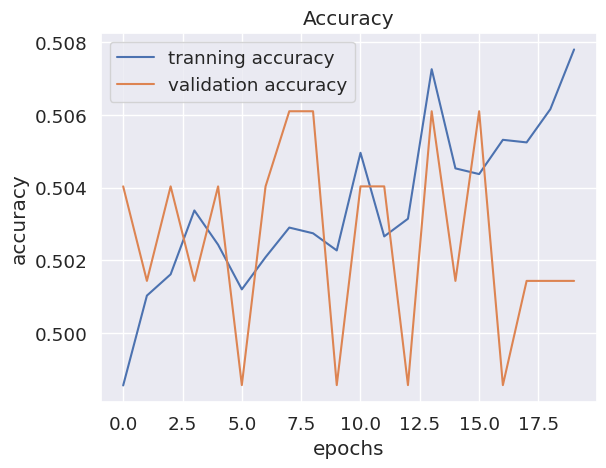

In [95]:
#accuracy
plt.figure(0)
plt.plot(history.history['accuracy'],label='tranning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

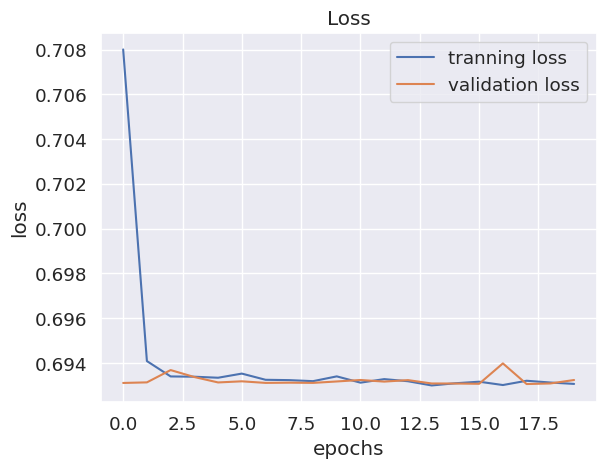

In [96]:
plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show